In [1]:
from pybaseball import statcast
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
#import all pitches from 2021 season into dataframe
statcast_data = statcast('2020-12-01', '2021-12-01')

This is a large query, it may take a moment to complete


/opt/anaconda3/envs/minimal_ds/lib/python3.10/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [01:11<00:00,  3.44it/s]


In [3]:
statcast_data.info() #view dataset information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720637 entries, 109 to 4054
Data columns (total 92 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   pitch_type                       720272 non-null  object        
 1   game_date                        720637 non-null  datetime64[ns]
 2   release_speed                    720235 non-null  Float64       
 3   release_pos_x                    720059 non-null  Float64       
 4   release_pos_z                    720059 non-null  Float64       
 5   player_name                      720637 non-null  object        
 6   batter                           720637 non-null  Int64         
 7   pitcher                          720637 non-null  Int64         
 8   events                           184107 non-null  object        
 9   description                      720637 non-null  object        
 10  spin_dir                         0 non-null 

In [14]:
#determine relevant columns --> these columns were chosen by intuition. I am only interested in using statcast data to predict the pitch
df_relevant = statcast_data[['pitch_type','release_speed','p_throws','pfx_x','pfx_z','plate_x','plate_z','vx0','vy0','vz0','ax','ay','az','release_spin_rate','pitch_name','spin_axis']].reset_index(drop=True)
df_relevant

,pitch_type,release_speed,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,pitch_name,spin_axis
0,FF,93.7,L,0.57,1.21,0.19,2.68,-4.348927,-136.263269,-7.335202,8.101619,29.384843,-15.743652,2112,4-Seam Fastball,146
1,FF,92.9,L,0.9,1.34,0.01,2.12,-5.455433,-134.989926,-8.881689,12.188852,30.69001,-14.009571,2206,4-Seam Fastball,145
2,FF,93.1,L,0.81,1.52,0.78,2.13,-3.230974,-135.201801,-9.255781,10.67848,31.699974,-11.7058,2216,4-Seam Fastball,143
3,FF,94.6,L,0.85,1.27,-0.23,2.66,-5.901934,-137.422092,-7.652311,12.118242,35.102245,-14.577857,2263,4-Seam Fastball,140
4,FF,93.6,L,0.9,1.43,-1.15,1.51,-8.265487,-135.578023,-10.936295,12.932808,31.370147,-12.168466,2239,4-Seam Fastball,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720632,FF,95.9,R,-0.17,0.86,0.07,3.09,5.561971,-139.787362,-4.509214,-3.312501,24.833759,-20.112617,2113,4-Seam Fastball,212
720633,FF,95.4,R,-0.06,0.68,0.52,3.95,5.875569,-139.018112,-1.839219,-1.810341,24.856947,-23.06789,<NA>,4-Seam Fastball,<NA>
720634,FF,96.1,R,-0.42,0.86,-0.61,3.65,3.953292,-140.09228,-3.371124,-6.331036,25.767684,-20.177597,2063,4-Seam Fastball,208
720635,FF,95.6,R,-0.25,0.88,0.19,2.6,6.352185,-139.293012,-5.428763,-4.405496,25.441128,-19.766641,2988,4-Seam Fastball,195


In [15]:
df_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720637 entries, 0 to 720636
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pitch_type         720272 non-null  object 
 1   release_speed      720235 non-null  Float64
 2   p_throws           720637 non-null  object 
 3   pfx_x              720269 non-null  Float64
 4   pfx_z              720269 non-null  Float64
 5   plate_x            720269 non-null  Float64
 6   plate_z            720269 non-null  Float64
 7   vx0                720269 non-null  Float64
 8   vy0                720269 non-null  Float64
 9   vz0                720269 non-null  Float64
 10  ax                 720269 non-null  Float64
 11  ay                 720269 non-null  Float64
 12  az                 720269 non-null  Float64
 13  release_spin_rate  717609 non-null  Int64  
 14  pitch_name         720272 non-null  object 
 15  spin_axis          717645 non-null  Int64  
dtypes:

<AxesSubplot:>

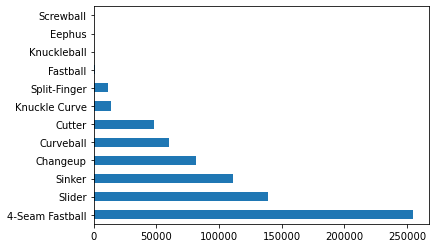

In [18]:
df_relevant['pitch_name'].value_counts().plot(kind='barh')

In [11]:
df_relevant.describe() #descriptive statistics for numerical values

,release_speed,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis
count,720235.000000,720269.000000,720269.000000,720269.000000,720269.000000,720269.000000,720269.000000,720269.000000,720269.000000,720269.000000,720269.000000,717609.000000,717645.000000
mean,88.863052,-0.106996,0.655249,0.044113,2.274805,2.109954,-129.241973,-4.109277,-2.016540,26.652685,-23.295020,2235.904102,175.763366
std,6.053331,0.866945,0.749900,0.846251,0.985328,5.906189,8.762635,3.134675,10.562398,3.967949,9.056762,337.787358,70.924212
min,30.100000,-2.560000,-2.130000,-6.100000,-5.070000,-18.902697,-150.384713,-20.138144,-35.092977,-2.089829,-51.301206,43.000000,0.000000
25%,84.600000,-0.840000,0.190000,-0.530000,1.640000,-2.927206,-136.272362,-6.206549,-10.909218,23.675024,-29.741887,2074.000000,134.000000
50%,89.900000,-0.180000,0.760000,0.040000,2.280000,3.805308,-130.701257,-4.239500,-2.080913,26.605351,-22.824502,2257.000000,198.000000
75%,93.700000,0.590000,1.280000,0.620000,2.920000,6.490080,-123.167338,-2.174430,6.189999,29.615474,-15.412595,2433.000000,221.000000
max,103.400000,2.840000,3.040000,9.110000,9.390000,20.914518,-40.422498,15.486221,29.761284,47.935965,16.787233,3722.000000,360.000000


In [36]:
df_relevant.isna().sum() #see how many null values are in the dataset

pitch_type            365
release_speed         402
p_throws                0
pfx_x                 368
pfx_z                 368
plate_x               368
plate_z               368
vx0                   368
vy0                   368
vz0                   368
ax                    368
ay                    368
az                    368
release_spin_rate    3028
pitch_name            365
spin_axis            2992
dtype: int64

Most of the columns has 368 missing values. This leads me to believe it is the same rows for each of the columns. Since there are over 700,000 rows in the dataset, it is probably best to remove these rows. The same may be said for the spin rate and spin axis. 

In [37]:
df_relevant.nunique()

pitch_type               13
release_speed           583
p_throws                  2
pfx_x                   461
pfx_z                   430
plate_x                 795
plate_z                 942
vx0                  720268
vy0                  720269
vz0                  720268
ax                   720269
ay                   720269
az                   720269
release_spin_rate      3105
pitch_name               12
spin_axis               361
dtype: int64

I noticed that pitch_type and pitch_name have different numbers of unique values, although they are both referring to the same thing. I investigated below

In [13]:
df_relevant['pitch_type'].value_counts()

FF    254519
SL    138908
SI    111078
CH     81528
CU     60099
FC     47853
KC     14013
FS     11075
FA       725
CS       316
KN        81
EP        76
SC         1
Name: pitch_type, dtype: int64

In [14]:
df_relevant['pitch_name'].value_counts()

4-Seam Fastball    254519
Slider             138908
Sinker             111078
Changeup            81528
Curveball           60415
Cutter              47853
Knuckle Curve       14013
Split-Finger        11075
Fastball              725
Knuckleball            81
Eephus                 76
Screwball               1
Name: pitch_name, dtype: int64

The pitch_type column as a value 'CS' that does not correspond to anything from the pitch_name column

In [15]:
df_relevant[df_relevant['pitch_type'] == 'CS'].head(5)

,pitch_type,release_speed,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,pitch_name,spin_axis
10336,CS,67.8,R,1.43,-1.3,1.69,1.0,3.100946,-98.54461,0.446421,8.514053,19.472324,-40.849224,2622,Curveball,39
25955,CS,69.8,L,-2.15,-0.24,-0.77,2.49,-2.556083,-101.365132,4.623964,-14.039311,20.242167,-34.957753,2636,Curveball,274
25957,CS,67.9,L,-2.33,0.06,-0.07,3.23,-1.146932,-98.499702,5.811309,-14.679986,19.235388,-33.190684,2744,Curveball,273
25964,CS,67.7,L,-2.31,0.16,-0.6,3.03,-1.84581,-98.216616,5.715581,-14.255159,20.236141,-32.618932,2697,Curveball,272
25965,CS,66.6,L,-2.28,0.25,1.04,3.01,1.035509,-96.632806,5.622793,-14.220294,18.894316,-31.992749,2649,Curveball,270


It looks like 'CS' is being classified as 'curveball'

In [16]:
df_relevant[df_relevant['pitch_type'] == 'CU'].head(5)

,pitch_type,release_speed,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,pitch_name,spin_axis
18,CU,77.2,L,-0.79,-1.09,1.06,4.8,0.288752,-112.269839,4.402666,-6.664866,23.089543,-42.468284,1938,Curveball,325
21,CU,84.4,R,0.62,-0.03,0.14,1.53,4.887751,-122.936949,-2.193857,5.357669,23.999432,-32.271503,2562,Curveball,76
22,CU,82.0,R,1.35,-0.56,1.19,0.39,5.812482,-119.201895,-3.287973,11.467446,26.102005,-36.951864,2778,Curveball,67
23,CU,83.5,R,1.43,-0.52,0.44,1.51,3.944388,-121.494864,-1.066441,13.157535,26.76832,-37.267542,2810,Curveball,68
25,CU,82.5,R,0.82,-0.25,-0.08,2.42,4.278948,-120.133698,0.524597,7.147985,22.252259,-34.942785,2559,Curveball,73


Both 'CU' and 'CS' refer to curveball, although 'CU is much more prevelant

In [20]:
#drop pitch_type column due to label confusion
df_drop_type = df_relevant.drop(columns='pitch_type')

In [59]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_drop_type, test_size=0.25)

X_train = train.drop(columns='pitch_name')
X_test = test.drop(columns='pitch_name')
y_train = train['pitch_name']
y_test = test['pitch_name']

In [56]:
pitches = train.copy()

In [82]:
pitches.isnull()

,release_speed,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis
606188,False,False,False,False,False,False,False,False,False,False,False,False,False,False
508290,False,False,False,False,False,False,False,False,False,False,False,False,False,False
716032,False,False,False,False,False,False,False,False,False,False,False,False,False,False
505815,False,False,False,False,False,False,False,False,False,False,False,False,False,False
92499,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173010,False,False,False,False,False,False,False,False,False,False,False,False,False,False
348583,False,False,False,False,False,False,False,False,False,False,False,False,False,False
372703,False,False,False,False,False,False,False,False,False,False,False,False,False,False
603807,False,False,False,False,False,False,False,False,False,False,False,False,False,False


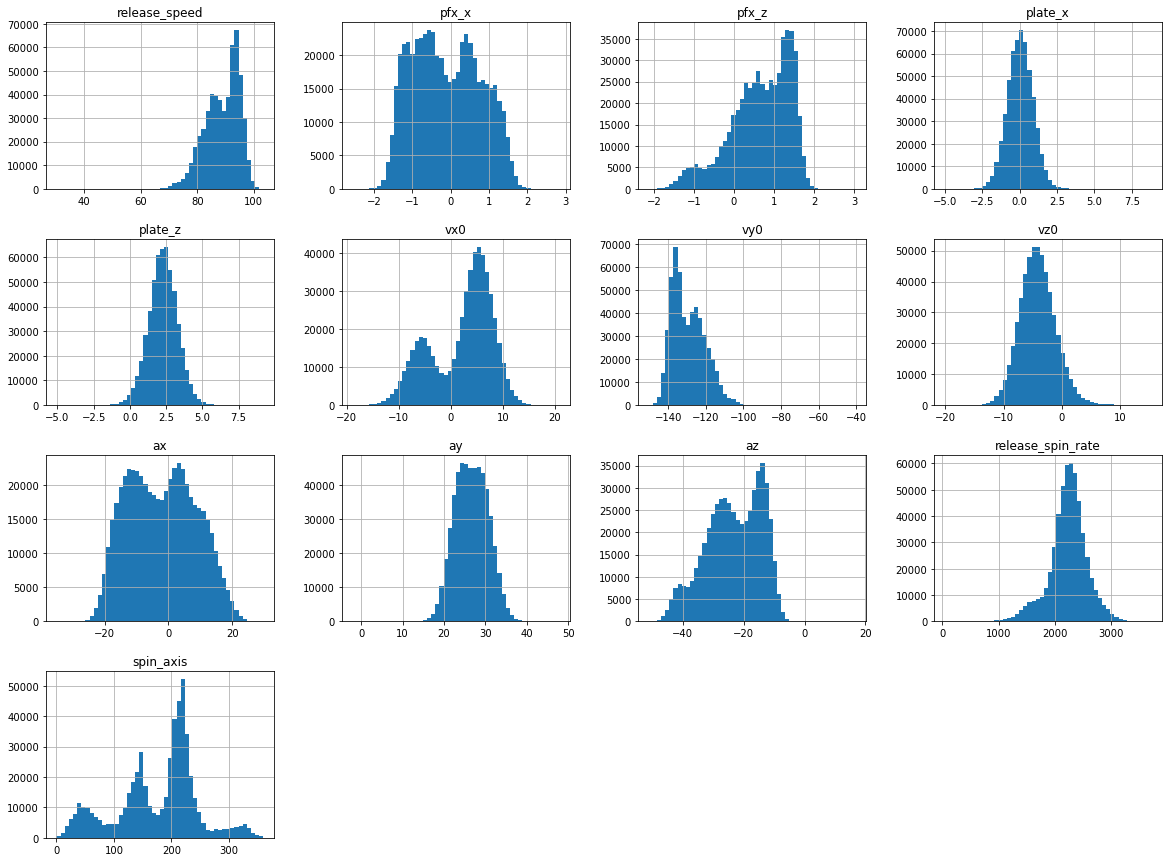

In [57]:
pitches.hist(bins = 50, figsize = (20,15))
plt.show()

<AxesSubplot:>

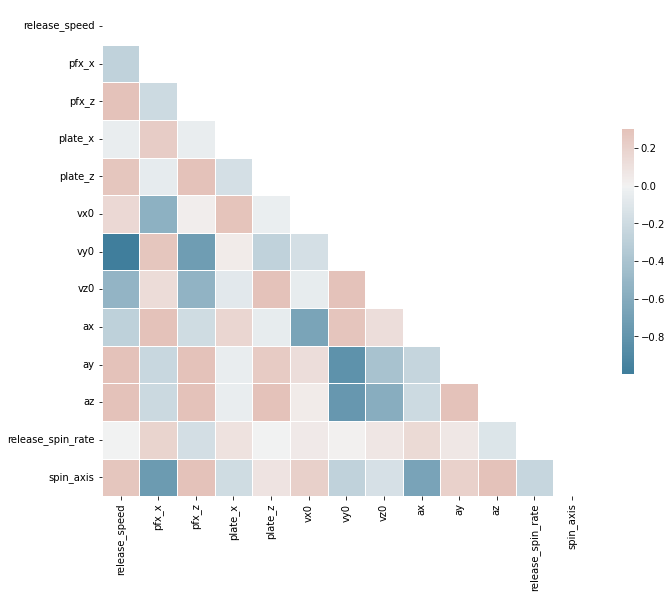

In [58]:
import seaborn as sns

corr = pitches.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=0.5, cbar_kws={'shrink':0.5})

# Preparing Data for Machine Learning

In [60]:
pitches = train.drop(columns='pitch_name')
pitch_labels = train['pitch_name'].copy()

## Dealing with missing rows

In [61]:
sample_incomplete_rows = pitches[pitches.isnull().any(axis=1)].head()
sample_incomplete_rows

,release_speed,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis
713534,94.9,L,0.18,1.38,0.43,2.59,-5.535603,-138.087533,-4.478044,3.479339,29.191002,-13.65375,<NA>,<NA>
476694,82.7,L,1.17,0.54,1.42,1.37,-2.805542,-120.357578,-5.849372,11.902727,23.86572,-25.944975,<NA>,<NA>
473067,80.8,L,-1.02,-0.38,-2.91,0.24,-10.620141,-117.166103,-4.491808,-7.080322,24.706723,-34.912436,<NA>,<NA>
282891,<NA>,L,0.87,1.26,-0.19,3.43,-3.945841,-137.570109,-5.13379,11.894041,32.934878,-15.218398,<NA>,147
472970,96.5,R,-0.92,1.26,-0.08,3.42,9.701812,-140.0537,-4.464828,-14.402953,34.358062,-14.78536,<NA>,<NA>


In [72]:
rows_to_drop = list(pitches[pitches['release_spin_rate'].isna()].index) #get index for 2660 missing spin rate rows
pitches_tr = pitches.drop(index=rows_to_drop) #drop rows

In [74]:
pitches_cat = pitches[['p_throws']]
pitches_cat

,p_throws
606188,R
508290,R
716032,L
505815,R
92499,L
...,...
173010,R
348583,R
372703,L
603807,L


In [76]:
pitches_tr

,release_speed,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis
606188,93.9,R,-0.53,1.38,-0.62,5.35,6.351316,-136.623818,0.96821,-8.12801,31.893351,-15.412267,2275,218
508290,98.5,R,-0.3,1.55,0.82,2.7,6.081567,-143.293621,-7.846049,-5.49328,31.356323,-9.211401,2324,208
716032,89.8,L,-0.45,0.83,-0.38,1.56,-7.152132,-130.437869,-6.20657,-3.434774,29.912328,-21.488802,2541,155
505815,94.3,R,-1.06,1.51,0.42,1.74,6.617561,-136.947407,-7.37513,-14.824926,34.116345,-11.712174,2242,208
92499,92.1,L,0.62,1.04,0.19,3.53,-5.568704,-134.03533,-2.442325,8.682886,27.639199,-19.265336,2141,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173010,85.5,R,0.95,-0.48,0.55,2.86,2.808272,-124.423669,-0.286289,9.205852,27.097646,-37.341839,2957,37
348583,85.3,R,0.18,0.09,-0.73,3.63,2.710233,-124.228085,1.444618,1.335363,22.775447,-31.649166,2396,113
372703,92.3,L,-0.07,1.44,-1.56,1.98,-6.918825,-134.161319,-7.61803,0.713002,29.472457,-13.316015,2121,157
603807,95.6,L,1.25,0.97,-0.15,3.2,-9.596796,-139.034002,-3.348973,18.242617,28.174885,-18.928404,2439,124


In [75]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)

pitches_1hot = cat_encoder.fit_transform(pitches_cat)

pitches_1hot

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [122]:
pitches = train.drop("pitch_name", axis=1)

pitching_labels = train["pitch_name"].copy()

def data_transformations(data):

    ### Separate Labels if they Exist ###

    if "pitch_name" in data.columns:
        labels = data["pitch_name"]
        data = data.drop("pitch_name", axis=1)
        
    else:
        labels = None

    features = list(pitches.columns)
    
    ### Removing null Data ###
   
    rows_to_drop = list(data[data['release_spin_rate'].isna()].index) #get index for 2660 missing spin rate rows
    pitches_tr = data.drop(index=rows_to_drop)
    labels = labels.drop(index=rows_to_drop)
    pitches_num = pitches_tr.select_dtypes(include=[np.number])

    ### Encoding Categorical Data ###
    pitches_cat = pitches_tr.select_dtypes(exclude=[np.number])

    from sklearn.preprocessing import OneHotEncoder
    cat_encoder = OneHotEncoder(sparse=False)
    pitches_cat_1hot = cat_encoder.fit_transform(pitches_tr[["p_throws"]])
    features = features + cat_encoder.categories_[0].tolist()
    features.remove("p_throws") # We're encoding this variable, so we don't need it in our list anymore


    ### Scaling Numerical Data ###
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()

    pitches_scaled = scaler.fit_transform(pitches_num)

    ### Concatening all Data ###
    output = np.hstack([pitches_scaled, pitches_cat_1hot])

    return output, labels, features

In [123]:
train_data, train_labels, features = data_transformations(train)
train_data

array([[ 0.43956044, -0.24475524,  0.56880734, ...,  0.22988506,
         0.        ,  1.        ],
       [ 0.94505495, -0.08391608,  0.72477064, ...,  0.11494253,
         0.        ,  1.        ],
       [-0.01098901, -0.18881119,  0.06422018, ..., -0.49425287,
         1.        ,  0.        ],
       ...,
       [ 0.26373626,  0.07692308,  0.62385321, ..., -0.47126437,
         1.        ,  0.        ],
       [ 0.62637363,  1.        ,  0.19266055, ..., -0.85057471,
         1.        ,  0.        ],
       [ 0.20879121,  0.17482517, -0.24770642, ...,  0.02298851,
         0.        ,  1.        ]])

In [124]:
test_data, test_labels, test_features = data_transformations(test)

In [126]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
clf = lgb.LGBMClassifier(objective='multiclass')
clf.fit(train_data, train_labels)
light_gbm_predictions = clf.predict(test_data)
accuracy_score(light_gbm_predictions, test_labels)


0.8066109528402344

In [144]:
preds = pd.DataFrame(light_gbm_predictions, columns=['prediction'])

In [145]:
preds

,prediction
0,Cutter
1,4-Seam Fastball
2,4-Seam Fastball
3,Split-Finger
4,Cutter
...,...
179398,Cutter
179399,4-Seam Fastball
179400,Sinker
179401,Cutter


In [154]:
actual = pd.DataFrame(y_test).reset_index()
actual.drop(columns='index',inplace=True)
actual

,pitch_name
0,Cutter
1,4-Seam Fastball
2,4-Seam Fastball
3,Split-Finger
4,Cutter
...,...
179398,4-Seam Fastball
179399,4-Seam Fastball
179400,Sinker
179401,Slider


In [155]:
preds_vs_actual = preds.join(actual, how='left')

In [156]:
preds_vs_actual

,prediction,pitch_name
0,Cutter,Cutter
1,4-Seam Fastball,4-Seam Fastball
2,4-Seam Fastball,4-Seam Fastball
3,Split-Finger,Split-Finger
4,Cutter,Cutter
...,...,...
179398,Cutter,4-Seam Fastball
179399,4-Seam Fastball,4-Seam Fastball
179400,Sinker,Sinker
179401,Cutter,Slider


In [157]:
preds_vs_actual['correct'] = preds_vs_actual['prediction'] == preds_vs_actual['pitch_name']

In [158]:
preds_vs_actual

,prediction,pitch_name,correct
0,Cutter,Cutter,True
1,4-Seam Fastball,4-Seam Fastball,True
2,4-Seam Fastball,4-Seam Fastball,True
3,Split-Finger,Split-Finger,True
4,Cutter,Cutter,True
...,...,...,...
179398,Cutter,4-Seam Fastball,False
179399,4-Seam Fastball,4-Seam Fastball,True
179400,Sinker,Sinker,True
179401,Cutter,Slider,False


In [161]:
preds_vs_actual['correct'].describe()

count     179403
unique         2
top         True
freq      146430
Name: correct, dtype: object

In [162]:
146430/179403

0.8162070868380128

12/29 notes
1. Look into dimensionality reduction
2. Think about anomaly detection for a slightly different project?

In [ ]:
#Retrying experiment with barebones data